In [1]:
#-- ---------------------------------------------------------------------------------------
# Developer:  Maurice Johnson
# Date:       04/30/2020
# Scope:      Developing an AI application
#-- ---------------------------------------------------------------------------------------
# Going forward, AI algorithms will be incorporated into more and more everyday applications. 
# For example, you might want to include an image classifier in a smart phone app. To do this, 
# you'd use a deep learning model trained on hundreds of thousands of images as part of the 
# overall application architecture. A large part of software development in the future will 
# be using these types of models as common parts of applications. 
#
# In this project, you'll train an image classifier to recognize different species of flowers. 
# You can imagine using something like this in a phone app that tells you the name of the 
# flower your camera is looking at. In practice you'd train this classifier, then export it for 
# use in your application. 
#
# We'll be using [this dataset]
# (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, 
# you can see a few examples below. 
# <img src='assets/Flowers.png' width=500px>
#
# The project is broken down into multiple steps:
# * Load and preprocess the image dataset
# * Train the image classifier on your dataset
# * Use the trained classifier to predict image content
#
# We'll lead you through each part which you'll implement in Python.
# When you've completed this project, you'll have an application that can be trained on any 
# set of labeled images. Here your network will be learning about flowers and end up as a command 
# line application. But, what you do with your new skills depends on your imagination and effort 
# in building a dataset. For example, imagine an app where you take a picture of a car, it tells 
# you what the make and model is, then looks up information about it. Go build your own dataset 
# and make something new.
#
# First up is importing the packages you'll need. It's good practice to keep all the imports 
# at the beginning of your code. As you work through this notebook and find you need to import a 
# package, make sure to add the import up here.

In [59]:
# Package Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from collections import OrderedDict
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
# Training data augmentation - Data normalization
data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

validate_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
# Data loading
image_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
validate_datasets = datasets.ImageFolder(valid_dir, transform=validate_transforms)

#Validate loading of datasets
#print(image_datasets[10])
#print(test_datasets[10])
#print(validate_datasets[10])

# TODO: Using the image datasets and the trainforms, define the dataimageloader
# Data batching
dataimageloader = torch.utils.data.DataLoader(image_datasets, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=64)
validateloader = torch.utils.data.DataLoader(validate_datasets,batch_size=64)

#Validate dataloaders
#print(dataimageloader.dataset[0][0].shape) #3,224,224
#print(dataimageloader.dataset[0][0].size()) #3,224,224
#print(type(dataimageloader.dataset[0][0])) #Torch Tensor
#print(type(dataimageloader.dataset[0][1])) #int

#How many Classes are there? - 102
#print(len(image_datasets.classes)) 

#How many Classes are there? - 102
#print(len(test_datasets.classes)) 

#How many Classes are there? - 102
#print(len(validate_datasets.classes)) 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
#import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

#Validate loading of Category to Name Labels  
#print(cat_to_name)

#How many Categories are there? - 102
#print(len(cat_to_name))

#Validation of Image Dataset Categorization to Labels - Keep this in mind for Saving the Model Checkpoint
#flower_category_index = image_datasets.classes
#print(flower_category_index)
#print(image_datasets.class_to_idx)

# Building the Classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

In [6]:
# TODO: A new feedforward network is defined for use as a classifier using the features as input
#Retrieve the number of input features

#To ensure adequate use of device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model():
    # TODO: Load a Pretrained Network (vgg16)
    #Pretrained Network
    trained_model = models.vgg16(pretrained=True)
    
    #Freeze parameters to prevent training
    for param in trained_model.parameters():
        param.requires_grad = False

    return trained_model

def get_classifier(trained_model, num_of_desired_outputs):   
    #Classifier
    #Validate the Number of Output Features for this Trained Model
    #NOTE:  From before we are seeking 102 as noted in the Classes Count
    #       and the Category Count
    #print(trained_model.classifier[6].out_features) #1000
    
    #Number of Input Features
    num_of_input_features = trained_model.classifier[6].in_features

    #Chomp the layers of the Trained Model
    features = list(trained_model.classifier.children())[:-1]

    # Dynamically extend the output layer with number of outputs
    features.extend([nn.Linear(num_of_input_features, num_of_desired_outputs)]) 

    # Replace the trained model classifier with our designated output layer size
    classifier = nn.Sequential(*features) 

    return classifier

#Retrieve the number of outputs required
num_of_desired_outputs = len(image_datasets.classes)

#Get the Model
trained_model = get_model()

#Get the Classifier
trained_classifier = get_classifier(trained_model, num_of_desired_outputs)

# Set the classifier to the trained model
trained_model.classifier = trained_classifier
    
#Number of Input Features - Will be leveraged later when we save the checkpoint
num_of_input_features = trained_model.classifier[6].in_features
    
#Validate the model
#print(trained_model)

## Training, Validating, and Testing your network

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [7]:
# TODO: The parameters of the feedforward classifier are appropriately trained, 
#       while the parameters of the feature network are left static

# TODO: The network's accuracy is measured on the test data

# TODO: During training, the validation loss and accuracy are displayed

#Establish the Loss Function
#loss_criterion = nn.NLLLoss()
loss_criterion = nn.CrossEntropyLoss()

#Establish the Optimizer - Filter out the Frozen Parameters Only train the classifier parameters
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, trained_model.classifier.parameters()), lr=0.003)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, trained_model.classifier.parameters()), lr=0.001, momentum=0.9)

#Validate Optimizer
#print(optimizer)

#Move the model to the designate device
trained_model.to(device)

#Record the amount of time for training the model
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

#Proceed to Train the New Neural Network
epochs = 10
steps = 0
running_loss = 0
cycle_every = 25

#Transition the Model to the Training Mode
trained_model.train()
    
for epoch in range(epochs):  
    
    for images, labels in dataimageloader:
        steps += 1
          
        #Move images and labels to designate device
        images,labels = images.to(device), labels.to(device)    
        
        #Validate type, size, dim
        #print(type(images))  #<class 'torch.Tensor'>
        #print(type(labels))  #<class 'torch.Tensor'>
        #print(images.size()) #torch.Size([64, 3, 224, 224])
        #print(images.dim())  #4
        
        # zero the parameter gradients 
        #(Time elapsed at this step: 71016.375 millisecs)
        optimizer.zero_grad()
        
        # devise the output 
        #(Time elapsed at this step: 80399.429 millisecs)
        logps = trained_model.forward(images)
          
        # calculate the loss 
        #(Time elapsed at this step: 79864.281 millisecs)  
        loss = loss_criterion(logps, labels)
          
        # backwards prop - aggregate the gradients based on params 
        #(Time elapsed at this step: 79782.492 millisecs)  
        loss.backward()
          
        # update the params based upon gradient 
        #(Time elapsed at this step: 79896.265 millisecs)  
        optimizer.step()
        
        #aggregate loss over iterations
        running_loss += loss.item()
        
        #Test Network accuracy
        if steps % cycle_every ==0:
             #Transition the Model to Evaluation Mode
                  trained_model.eval()
                  
                  test_loss = 0
                  
                  accuracy = 0
                  
                  #Validation Loop
                  for images,labels in testloader:
                       images,labels = images.to(device), labels.to(device)
                       
                       logps = trained_model.forward(images)
                        
                       loss = loss_criterion(logps,labels)
                    
                       test_loss += loss.item()
                       
                       #calculate our accuracy
                       ps = torch.exp(logps)
                       
                       #Top Probabilities and Top Classes along columns
                       top_ps,top_class = ps.topk(1,dim=1)
                       
                       equality = top_class == labels.view(*top_class.shape)
                       
                       accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                       
                  #Report Testing Results
                  print(f"Epoch {epoch+1}/{epochs}..)"
                        f"Train Loss: {running_loss/cycle_every:.3f}.. "
                        f"Test Loss: {test_loss/len(testloader):.3f}.. "
                        f"Test Accuracy: {accuracy/len(testloader):.3f}")
                        
                  running_loss = 0
                  
                  #Transition the Model back to Training Mode
                  trained_model.train()
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training, Testing, and Validating')

#print('Elapsed Time(milliseconds):')
#print(start.elapsed_time(end)) # milliseconds: 137935.578125

# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
torch.cuda.empty_cache()

Epoch 1/10..)Train Loss: 0.000.. Test Loss: 4.231.. Test Accuracy: 0.126
Epoch 1/10..)Train Loss: 0.000.. Test Loss: 3.797.. Test Accuracy: 0.213
Epoch 1/10..)Train Loss: 0.000.. Test Loss: 3.438.. Test Accuracy: 0.315
Epoch 1/10..)Train Loss: 0.000.. Test Loss: 3.125.. Test Accuracy: 0.369
Epoch 2/10..)Train Loss: 0.000.. Test Loss: 2.895.. Test Accuracy: 0.430
Epoch 2/10..)Train Loss: 0.000.. Test Loss: 2.672.. Test Accuracy: 0.496
Epoch 2/10..)Train Loss: 0.000.. Test Loss: 2.524.. Test Accuracy: 0.506
Epoch 2/10..)Train Loss: 0.000.. Test Loss: 2.370.. Test Accuracy: 0.529
Epoch 3/10..)Train Loss: 0.000.. Test Loss: 2.228.. Test Accuracy: 0.591
Epoch 3/10..)Train Loss: 0.000.. Test Loss: 2.122.. Test Accuracy: 0.595
Epoch 3/10..)Train Loss: 0.000.. Test Loss: 2.025.. Test Accuracy: 0.610
Epoch 3/10..)Train Loss: 0.000.. Test Loss: 1.933.. Test Accuracy: 0.638
Epoch 4/10..)Train Loss: 0.000.. Test Loss: 1.862.. Test Accuracy: 0.637
Epoch 4/10..)Train Loss: 0.000.. Test Loss: 1.789..

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
# TODO: There is a function that successfully loads a checkpoint and rebuilds the model

# TODO: The trained model is saved as a checkpoint along with associated hyperparameters 
#       and the class_to_idx dictionary

#print("Our model:\n\n", trained_model, '\n')
#print("The state dict keys: \n\n", trained_model.state_dict().keys())
#print("Recalling the Input and Output Size: \n")
#print("  Input Size: ", num_of_input_features)
#print("  Output Size: ", num_of_desired_outputs)
 
#TODO:  Saving the Checkpoint will be unique to the model architecture...
checkpoint_file_name = 'my_model_chckpnt.pt'
    
torch.save({
            'input_size': num_of_input_features,
            'output_size': num_of_desired_outputs,
            'epoch': epoch+1,
            'batch_size': 64,
            'model': models.vgg16(pretrained=True),
            'classifier': trained_classifier,
            'optimizer': optimizer.state_dict(),
            'state_dict': trained_model.state_dict(),
            'loss': loss,
            'class_to_idx': image_datasets.class_to_idx
            }, checkpoint_file_name)

print('Trained Model Checkpoint Saved...\n')
print('File         :', checkpoint_file_name)
print('Access time  :', time.ctime(os.path.getatime(checkpoint_file_name)))
print('Modified time:', time.ctime(os.path.getmtime(checkpoint_file_name)))
print('Change time  :', time.ctime(os.path.getctime(checkpoint_file_name)))
print('Size         :', os.path.getsize(checkpoint_file_name))

Trained Model Checkpoint Saved...

File         : my_model_chckpnt.pt
Access time  : Tue Apr 28 15:42:14 2020
Modified time: Tue Apr 28 17:52:52 2020
Change time  : Tue Apr 28 17:52:52 2020
Size         : 1093851675


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_file_name):
    if os.path.isfile(checkpoint_file_name):
        #print('Filename exists!!!')
        
        model_checkpoint = torch.load(checkpoint_file_name)
        
        new_model = model_checkpoint['model']
        
        new_model.classifier = model_checkpoint['classifier']
        
        #new_model.load_state_dict(model_checkpoint['state_dict'])
        new_model.load_state_dict(model_checkpoint['state_dict'], strict=False)
    
        last_epoch = model_checkpoint['epoch']
        
        input_size = model_checkpoint['input_size']
        
        output_size = model_checkpoint['output_size']
        
        loss = model_checkpoint['loss']
        
        class_to_idx = model_checkpoint['class_to_idx']
                 
        optimizer = model_checkpoint['optimizer']
        
        for param in new_model.parameters():
            param.requires_grad = False
    else:
        print('Filename does not exist.  Please try again.')        
    
    return new_model, last_epoch, input_size, output_size, optimizer, loss, class_to_idx
    
#----------------------------------------------------------------------------------    
#Validate load_checkpoint function usage    
#new_model = get_model(num_of_input_features, num_of_desired_outputs)

#Load Model Checkpoint
#new_model, last_epoch, input_size, output_size, optimizer, loss, class_to_idx = \
#load_checkpoint(new_model, 'my_model_chckpnt.pt')

#validate Checkpoint Load
#print('Last Epoch   :\n', last_epoch)
#print('Input Size   :\n', input_size)
#print('Output Size  :\n', output_size)  
#print('Loss         :\n', loss)    
#print('Model        :\n', new_model)
#print('Optimizer    :\n', optimizer)  
#print('Class2Indx   :\n', class_to_idx)  
#----------------------------------------------------------------------------------  


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [34]:
#TODO:  The process_image function successfully converts a PIL image into an object 
#       that can be used as input to a trained model
#
# TODO: Process a PIL image for use in a PyTorch model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image_transformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = image_transformer(image)
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    #"""Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    ## PyTorch tensors assume the color channel is the first dimension
    ## but matplotlib assumes is the third dimension
    ##image = image.numpy().transpose((1, 2, 0))
    image = np.transpose(image[0], (1, 2, 0))
    
    ## Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    #image = std * image + mean
    image[0] = image[0] * std[0] + mean[0]
    
    ## Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

#-------------------------------------------------------------
#Test imshow and process_image functions
#image = process_image('flowers/train/1/image_06734.jpg')

#imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [38]:
#TODO:  The predict function successfully takes the path to an image and a checkpoint, 
#       then returns the top K most probably classes for that image
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #image_in_question = process_image(image_path)
    if os.path.isfile(image_path):
        #print('Image Filename Found!!!')
        
        image_in_question = Image.open(image_path)
        
        image_in_question = process_image(image_in_question)
    else:
        print('Prediction Function:  Image File NOT Found!!!')
        
    # Convert 2-Dimensional image to 1-Dimensional vector
    image_in_question = np.expand_dims(image_in_question, 0)
    
    image_in_question = torch.from_numpy(image_in_question)
    
    #Move model to device
    model.to(device)
    
    #Transition Model to Evaluation Mode
    model.eval()
    
    #Move Image to device
    inputs = Variable(image_in_question).to(device)
    
    #Pass Image into Model, caluculate raw output
    logits = model.forward(inputs)
    
    #Devise Probabilities from Raw Output
    probabilities = F.softmax(logits, dim=1)
    
    #Calculate the highest probabilities
    top_probabilities = probabilities.cpu().topk(topk)
    
    return (every_probality.data.numpy().squeeze().tolist() for every_probality in top_probabilities)
    
#--------------------------------------------------------------    
#Validate the Prediction Function    
img_path = 'flowers/train/1/image_06734.jpg'
img_path_02 = 'flowers/train/2/image_05111.jpg'

model_checkpoint = 'my_model_chckpnt.pt'

new_model, last_epoch, input_size, output_size, optimizer, loss, class_to_idx = \
 load_checkpoint(model_checkpoint)    

probabilities, flower_category = predict(img_path_02, new_model)

print(probabilities)
print(flower_category)

[0.9504877924919128, 0.010346533730626106, 0.005433369427919388, 0.004471631720662117, 0.003824687097221613]
[14, 61, 79, 4, 13]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

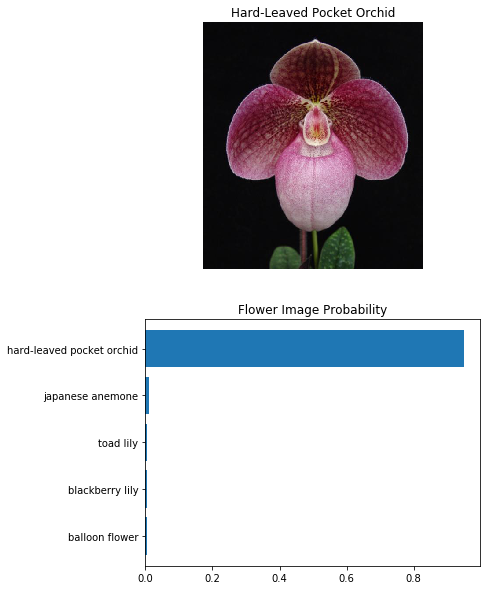

In [58]:
# TODO: A matplotlib figure is created displaying an image and its associated top 
#       5 most probable classes with actual flower names
def confirm_classification(img_path, probabilities, flower_category, mapping, flower_names):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #Show the image in question
    image = Image.open(img_path)
    
    #using tuple unpacking for multiple Axes(figuresize, number of cols, number of rows)
    fig, (axis_one, axis_two) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    flower_name = mapping[img_path.split('/')[-2]]
    flower_name = flower_name.title()
    
    axis_one.set_title(flower_name)
    axis_one.imshow(image)
    axis_one.axis('off')
    
    y_pos = np.arange(len(probabilities))
    
    axis_two.barh(y_pos, probabilities, align='center')
    axis_two.set_yticks(y_pos)
    axis_two.set_yticklabels(flower_names)
    axis_two.invert_yaxis()  
    axis_two.set_title('Flower Image Probability')
    
#Validate the accuracy of the prediction function    
flower_genius = image_datasets.classes

flower_names = [cat_to_name[flower_genius[flower_name]] for flower_name in flower_category]

#print(flower_names)

confirm_classification(img_path_02, probabilities, flower_category, cat_to_name, flower_names)